## ⚡Mission 2: Analyse plus ciblée des clients:


Dans cette mission, nous allons nous interesser à une analyse plus ciblée des clients, et aux liens entres les differentes variables.

### Plan 
Lien entre:
- Le genre(sexe) et les catégories des livres achetés 
- L'âge  et le montant total du panier 
- L'âge et la fréquence d'achat 
- L'âge et la taille du panier moyen 
- L'âge et les catégories des livres achetés 

📌<br /> 
### Comment choisir un test statistique ?
Concernant le choix des test statistiques, nous allons nous appuyer sur le tableau recapitulatif ci-dessous, selon le nombre de variables utilisées et leur type.
|Type of variables|Statistic Test|
|---|---|
|one numeric |t test|
|two numeric|correlation test|
|one numeric & one categorical|t test ou Anova|
|Two categorical|chi squared|

##### Préparation des données (selon nettoyage fait dans partie 1)

J' importe les modules necessaires pour l'analyse.

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest

Je charge les datasets dans les dataframes.
Et je fais le merge des trois fichiers.

In [9]:
df_customers = pd.read_csv('customers.csv')
df_products =pd.read_csv('products.csv')
df_transactions=pd.read_csv('transactions.csv')

#supprimer les valeurs de test pour transactions.
df_transactions = df_transactions[df_transactions["client_id"].str.startswith("ct")==False]
#supprimer les valeurs de test pour products.
df_products= df_products[df_products["id_prod"].str.startswith("T_0")==False]
#supprimer les valeurs de test pour customers.
df_customers = df_customers[df_customers["client_id"].str.startswith("ct")==False]

In [10]:
#merged transactions & products
trpr = pd.merge(df_transactions, df_products, on=['id_prod'])
#merged trpr & customers
troisfichier = pd.merge(trpr, df_customers, on=['client_id'])

#Je calcule l'âge pour chaque clients
now = 2023
troisfichier['age'] = now - troisfichier['birth']

#tranche d'âge
bins= [18,25,35,45,55,65,100]
labels = ['18-24','25-34','35-44','45-54','55-64','65+']
troisfichier['age_group'] = pd.cut(troisfichier['age'], bins=bins, labels=labels, right=False)
troisfichier.head(2)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,age_group
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986,37,35-44
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0,f,1986,37,35-44


 ✔️Ci-dessus j'ai déjà préparé le dataframe fusionné (incluant âge , tranche d'âge) : troisfichier 

Nous allons maintenant nous interesser plus en détails aux clients ciblées et aux liens entres les différentes variables. Nous utiliserons des tests statistiques pour prouver ou rejeter les liens.

## 🍄1. Genre et catégories des livres achetées
Il y a-t-il une corrélation entre le genre du client et la catégorie des livre achetées ?

   On va d'abord dessiner un diagramme de baton pour montrer le genre et la categorie des livres achetes par nombre de ventes. </br>
   Je calcule donc avant le nombre de ventes par genre et categorie : 

In [4]:
t1=troisfichier.copy()
t1= t1.groupby(['sex','categ'])["price"].count().rename("cnt").reset_index()
t1.head()

,sex,categ,cnt
0,f,0,206103
1,f,1,114899
2,f,2,17283
3,m,0,209356
4,m,1,112270


<AxesSubplot:xlabel='Genre'>

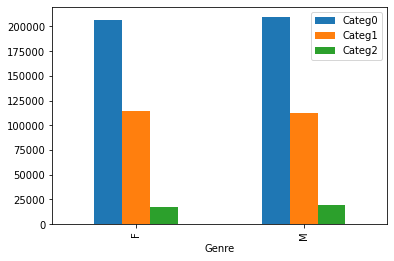

In [22]:
# creating dataframe
df = pd.DataFrame({
    'Genre': ['F' , 'M'],
    'Categ0': t1[t1.categ.eq(0)]['cnt'].values,
    'Categ1': t1[t1.categ.eq(1)]['cnt'].values,
    'Categ2': t1[t1.categ.eq(2)]['cnt'].values
})
# plotting graph
df.plot(x="Genre", y=['Categ0', 'Categ1', 'Categ2'], kind="bar")

On constate que le nombre de ventes pour les femmes et les hommes sont similaires. </br> 
Je vais donc faire le diagramme avec la part de CA.

In [5]:
t2=troisfichier.copy()
t2= t2.groupby(['sex','categ'])["price"].sum().rename("ca").reset_index()
t2.head(2)

,sex,categ,ca
0,f,0,2190013.07
1,f,1,2358417.02


<AxesSubplot:xlabel='Genre'>

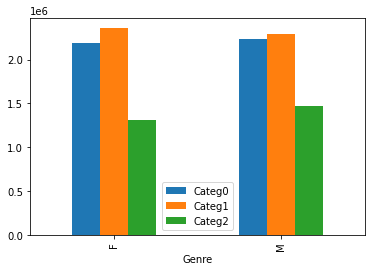

In [6]:
# creating dataframe
df = pd.DataFrame({
    'Genre': ['F' , 'M'],
    'Categ0': t2[t2.categ.eq(0)]['ca'].values,
    'Categ1': t2[t2.categ.eq(1)]['ca'].values,
    'Categ2': t2[t2.categ.eq(2)]['ca'].values
})
# plotting graph
df.plot(x="Genre", y=['Categ0', 'Categ1', 'Categ2'], kind="bar", title="Répartition par genre par catégorie")

La distributation du CA par genre et catégorie est aussi plus au moins similiaire. </br>
Maintenant, on va utiliser le test khi-deux d' indépendance.

#### ⚡Test statistique: </br>
Ici, le genre est une variable **qualitative nominale**, et la catégorie de livre est une variable **qualitative nominale**.  </br>
On peut utiliser le **test du khi-deux d'indépendance**. </br>
</br>
  Assomptions:</br>
- Les deux échantillons sont indépendants</br>
- Aucun nombre de cellules attendu n'est = 0</br>
- Pas plus de 20 % des cellules ont un nombre de cellules attendu < 5 </br>
</br>
Voici les hypothèses pour le test d'indépendance:
- H0:  il y pas de lien entre Genre(sexe) et la catégorie des livres achetées
- H1:  un lien corrélation

J'utilise *summary_cat* pour regarder les informations des deux varibles qui nous intéressent.

In [7]:
df_categ=troisfichier.copy()
rp.summary_cat(df_categ[["sex", "categ"]])

,Variable,Outcome,Count,Percent
0,sex,m,340826,50.19
1,,f,338285,49.81
2,categ,0,415459,61.18
3,,1,227169,33.45
4,,2,36483,5.37


On créer un table de contingence avec la fonction *crosstab* 

In [169]:
# nbt (nombre de ventes)
crosstab = pd.crosstab(df_categ["sex"],df_categ["categ"])
crosstab

categ,0,1,2
sex,,,
f,206103,114899,17283
m,209356,112270,19200


Ci-dessous ,on fait la même chose avec **normalize=True**. C'est juste pour regarder le ratio des ventes au lieu du nombre de ventes.

In [168]:
# nbt en ratio ( fréquance)
crosstab_ratio = pd.crosstab(df_categ["sex"],df_categ["categ"],normalize=True)
crosstab_ratio

categ,0,1,2
sex,,,
f,0.303489,0.169190,0.025449
m,0.308280,0.165319,0.028272


On execute le test chi-squared (khi-deux) en donnant en paramètre le tableau de contingence.

In [170]:
stats.chi2_contingency(crosstab)

(147.11906816131497,
 1.1310980597090762e-32,
 2,
 array([[206952.24759281, 113159.50583189,  18173.2465753 ],
        [208506.75240719, 114009.49416811,  18309.7534247 ]]))

Ce test retourne : 
- 1. **La Pearson Ch-square value**
- 2. **La p-value**
- 2. Le degrée de libérte (degree of freedom) : *(r -1 )x(c-1) = dof* 
- 4. Un tableau des valeurs expected.

La p-value est 0, donc on rejete l' hypothèse null. </br>
On peut donc dire qu'il y a un lien entre le genre et la catégorie.

On refait le test avec la function *crosstab* du module *researchpy* . </br>
L' avantage est que cette fonctiion execute aussi le **test V de Cramer**, qui permet de décrire l'intensité de la rélation entre les deux variables.

In [162]:
## voici le tableau de contingence 
crosstab, test_results, expected = rp.crosstab(df_categ["sex"], df_categ["categ"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
crosstab

categ                     
categ      0      1     2     All
sex                              
f      30.35  16.92  2.54   49.81
m      30.83  16.53  2.83   50.19
All    61.18  33.45  5.37  100.00

In [163]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,147.1191
1,p-value =,0.0000
2,Cramer's V =,0.0147


Ici , on a le résultat du test V de Cramer qui permet de comparer l'intensite de lien entre les deux variables.\
0.0147( > 0) indique un lien très faible entre le genre et la catégorie des livres.


|Phi and Cramer's V	|Interpretation|
|---|---|
|>0.25|Very strong|
|>0.15|Strong|
|>0.10|Moderate|
|>0.05|Weak|
|>0|No or very weak|

#### ✔️conclusion
Il y a un lien entre le genre et la catégorie. Mais ce lien est très faible.

## 🍄2. Age et montant total du panier
Ici, l'âge est une variable **quantitative continue**, et montant total du panier est une variable **quantitative continue**.  </br>


Comme les deux variables sont quantitatives, on peut utiliser un diagramme en nuage de point pour montrer leur correlation et la tendance.
Je calcule le montant total du panier de chaque client.
Chaque panier possede un numero de session unique (*session_id*). Donc pour trouver le montant du panier, on faire la somme des prix ayant la meme *session_id*.

In [38]:
df_basket =troisfichier.copy()
df_basket=df_basket.groupby(['session_id'], as_index=False).agg({'price':'sum' , 'age' :'first'}).rename(columns={"price":"montant du panier"})
df_basket.head()

,session_id,montant du panier,age
0,s_1,11.99,56
1,s_10,26.99,53
2,s_100,33.72,45
3,s_1000,39.22,34
4,s_10000,41.49,34


[Text(0.5, 1.0, "Prix du montant du panier, selon l'age")]

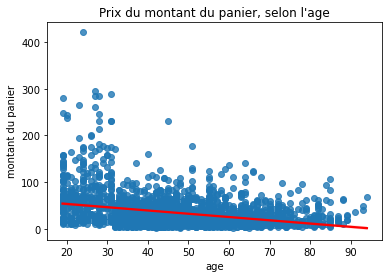

In [37]:
# On prend juste 3000 echantillons pour ne pas saturer le diagramme
df_basket_sample =df_basket.sample(3000)
# use the function regplot to make a scatterplot
sns.regplot(x=df_basket_sample["age"], y=df_basket_sample["montant du panier"],line_kws={"color": "red"}).set(title="Prix du montant du panier, selon l'age")

Avant de faire le test de Corrélation, on verifie que les données de la variable "montant du panier" sont normalement distribuées. 
On fait le test de normalité pour deux variables.  

Pourquoi utilisons-nous shapiro ? </br>
Il s'agit d'un test de normalité. </br>
H0 (Accepté) : l'échantillon correspond à une distribution normale. (P0 > 0,05) </br>
H1 (rejeté) : l'échantillon ne correspond pas à une distribution normale. </br>

In [47]:
# variable montant du panier
shapiro(df_basket_sample["montant du panier"]) 

ShapiroResult(statistic=0.7060815095901489, pvalue=0.0)

In [49]:
# variable montant de l'âge
shapiro(df_basket_sample["age"]) 

ShapiroResult(statistic=0.9829424023628235, pvalue=1.5337442297254105e-18)

Nos deux variable ne proviennent pas de distribution normal,  donc on ne va pas faire le test de correlation de Pearson, mais plutot **le test de correlation de Spearman** (Test non-parametrique)

#### ⚡Test statistique:
Voici les hypothèses pour le test de Corrélation (avec la mehode *Spearman*):
- H0:  il y pas de lien entre l'âge et le montant total du panier    
- H1:  un lien corrélation

In [26]:
#On veux seulement l'âge et le montant total du panier.
df_basket=df_basket[['age','price']].copy()
df_basket.head(2)

,age,price
0,56,11.99
1,53,26.99


In [58]:
# correlation
df_basket.corr(method="spearman")

,montant du panier,age
montant du panier,1.000000,-0.338193
age,-0.338193,1.000000


On obtient un coefficient de corrélation de -0.34. Il s' agit d'une corrélation faible négative.</br>
Le coefficient de corrélation de Spearman (r<sub>s</sub>) est compris entre -1 et 1, *r<sub>s</sub>* > 0 étant une corrélation positive et *r<sub>s</sub>* < 0 étant une corrélation négative. </br>
Plus la valeur absolue de *r<sub>s</sub>*  est grande, plus la corrélation entre les variables est forte.</br>

|Correlation Coeffient (r<sub>s</sub>) |Interpretation|
|---|---|
|0.9< (r<sub>s</sub>) <1|Very strong|
|0.7< (r<sub>s</sub>) <0.9|Strong|
|0.4< (r<sub>s</sub>) <0.7|Moderate|
|0.2< (r<sub>s</sub>) <0.4|Weak|
|0< (r<sub>s</sub>) <0.2|No or very weak|

On peut visualiser ce résultat avec une *heatmap*.

Text(0.5, 1.0, 'Correlation de Spearman')

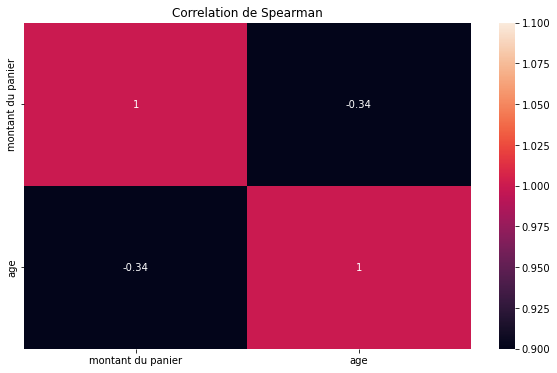

In [55]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_basket.corr(method="spearman"), vmin=1, vmax=1, annot=True)
plt.title("Correlation de Spearman")

Text(0.5, 1.0, 'Correlation de Pearson')

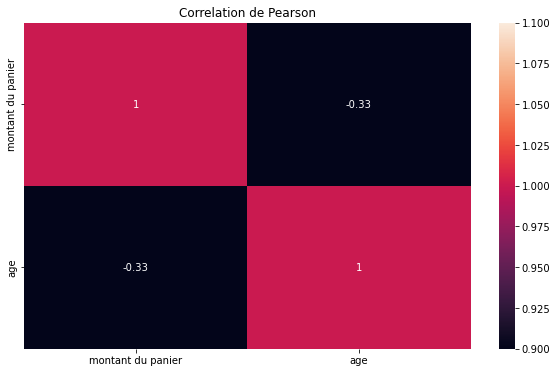

In [57]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_basket.corr(method="pearson"), vmin=1, vmax=1, annot=True)
plt.title("Correlation de Pearson")

In [100]:
stats.spearmanr(df_basket["age"], df_basket["montant du panier"])

SpearmanrResult(correlation=-0.33819314877296236, pvalue=0.0)

#### ✔️conclusion
La p-value est de 0, donc il y a un lien en l'age et le montant total du panier.
On peut constater qu'en fait la méthode de Pearson donne dans notre cas un resultat similaire, bien qu'on a échoué le test de normalité (assomption pour la méthode Pearson) <br>
Pour résumer, on peut conclure qu'**il y a une corrélation entre l'âge et le montant du panier**. Le coéfficient étant négatif, on peut dire que lorsque l'âge augmente, le montant total du panier a tendance à baisser.

## 🍄3. Age et fréquence d'achat
Ici, l'âge est une variable **quantitative continue**, et la fréquence d'achat est une variable **quantitative continue**.  </br>

Il y a-t-il une correlation en l'age et la frequence d'achat ?

Comme les deux variables sont quantitatives, on va utiliser un diagramme en nuage de point pour montrer leur correlation et la tendance. </br>
Je calcule d'abord le nombre d'achat de chaque client. Pour cela, je compte les *session_id* par client et par age.

In [62]:
df_achat=troisfichier.copy()
df_achat=df_achat.groupby(['client_id','age']).session_id.agg('count').reset_index(name='nombre d\'achat')
df_achat.head()

,client_id,age,nombre d'achat
0,c_1,68,39
1,c_10,67,58
2,c_100,31,8
3,c_1000,57,125
4,c_1001,41,102


<AxesSubplot:xlabel='age', ylabel="nombre d'achat">

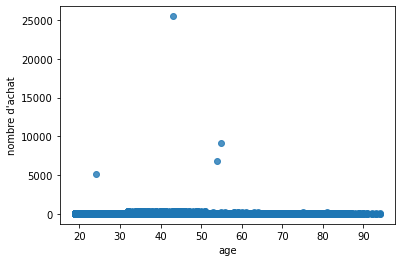

In [63]:
# use the function regplot to make a scatterplot
sns.regplot(x=df_achat["age"], y=df_achat["nombre d\'achat"])

On voit qu'il y a quatre points sur 5000 qui sont des valeurs aberrantes. </br>
La valeur aberrante maximale est 25 000, ce qui signifie  que 25 000 commandes ont ete passées par un seul client. Il doit certainement s'agir d'une commande fait par une entreprise, non par un client normal. </br>
Mous devons d'abord supprimer les valeurs aberrantes afin de voir la distribution et la tendance de la répartition des données.

[Text(0.5, 1.0, "Nombre d'achat selon age")]

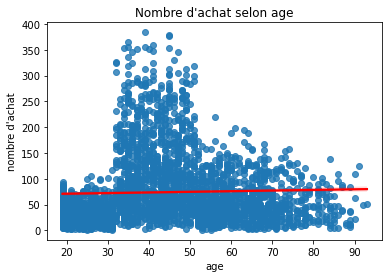

In [78]:
df_achat2 =df_achat[df_achat["nombre d\'achat"].lt(4000)]
#On prend un echantillon de 3000 individus pour ne pas saturer le diagramme
df_achat2 = df_achat2.sample(3000)
sns.regplot(x=df_achat2["age"], y=df_achat2["nombre d\'achat"],line_kws={"color": "red"}).set(title="Nombre d'achat selon age")

On constate que les clients entre 30 et 50 ans semble avoir tendance à acheter plus souvent.

Je verifie la moyenne du nombre d'achat par age ( les 5 ages avec le plus grand nombre d'achat)

In [83]:
df_achat2.groupby("age").agg({"nombre d\'achat":"mean"}).sort_values(by=["nombre d\'achat"],ascending=False).head()

,nombre d'achat
age,
45,136.520000
39,134.661290
38,130.547619
35,128.935065
49,125.264151


Avec la fonction *describe*, on peut voir que la moyenne global est de 68 achats, alors que pour les tops (entre 30 et 50) on a une moyenne presque double.

In [84]:
df_achat2.groupby("age").agg({"nombre d\'achat":"mean"}).sort_values(by=["nombre d\'achat"],ascending=False).describe()

,nombre d'achat
count,75.000000
mean,67.582353
std,32.855257
min,13.000000
25%,45.880769
50%,57.320000
75%,102.514645
max,136.520000


On fait le test de normalité **shapiro** sur les deux variables avant de choisir la methode pour le test de correlation </br>

H0 (Accepté) : l'échantillon correspond à une distribution normale. (P0 > 0,05) </br>
H1 (rejeté) : l'échantillon ne correspond pas à une distribution normale. </br>

In [85]:
# variable âge et variable nombre d'achat
shapiro(df_achat2["age"]) , shapiro(df_achat2["nombre d\'achat"]) 

(ShapiroResult(statistic=0.9709421396255493, pvalue=3.265601340980467e-24),
 ShapiroResult(statistic=0.8255009055137634, pvalue=0.0))

L'hyphothese null est rejetee, donc ces donnees ne sont pas d' une distributon normale. </br>
Je verifie aussi avec le test de **Kolmogorov-Smirnov** ( alternative a **shapiro**), qui est plus adapte dans le cas de grands echantillons.

In [77]:
# Ce test est une alternative lorsque les donnees sont nombreuses.
kstest(df_achat["nombre d\'achat"],'norm'), kstest(df_achat.age, 'norm')

KstestResult(statistic=0.9928361484799978, pvalue=0.0)

Nos deux variable ne proviennent pas de distribution normal,  donc on va faire le **test non-parametrique de correlation de Spearman** 

#### ⚡Test statistique: </br>
  **Test de correlation de Spearman**
- H0:  il y pas de lien entre age & frequence d'achat 
- H1:  un lien correlation

In [73]:
df_achat.corr(method="spearman")

,age,nombre d'achat
age,1.00000,0.12812
nombre d'achat,0.12812,1.00000


Text(0.5, 1.0, 'Correlation de Spearman')

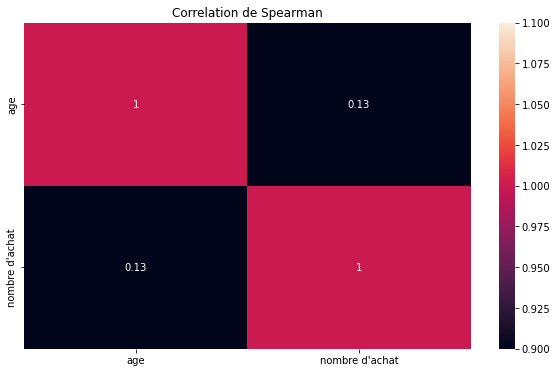

In [86]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_achat.corr(method="spearman"), vmin=1, vmax=1, annot=True)
plt.title("Correlation de Spearman")

On obtient un coefficient de corrélation de 0.13. Il s' agit d'une corrélation très faible.</br>
Le coefficient de corrélation de Spearman (r<sub>s</sub>) est compris entre -1 et 1, *r<sub>s</sub>* > 0 étant une corrélation positive et *r<sub>s</sub>* < 0 étant une corrélation négative. </br>
Plus la valeur absolue de *r<sub>s</sub>*  est grande, plus la corrélation entre les variables est forte.</br>

|Correlation Coeffient (r<sub>s</sub>) |Interpretation|
|---|---|
|0.9< (r<sub>s</sub>) <1|Very strong|
|0.7< (r<sub>s</sub>) <0.9|Strong|
|0.4< (r<sub>s</sub>) <0.7|Moderate|
|0.2< (r<sub>s</sub>) <0.4|Weak|
|0< (r<sub>s</sub>) <0.2|No or very weak|

In [90]:
# On verifie la p-value
stats.spearmanr(df_achat["age"], df_achat["nombre d\'achat"])

SpearmanrResult(correlation=0.1281196863733412, pvalue=8.377986603451065e-33)

#### ✔️conclusion
La p-value est de 0, donc **il y a bien un lien entre l'age et la frequence d'achat**. Mais il s'agit d'une correlation tres faible.

## 🍄4. Age et taille du panier moyen
#### *Il y a-t-il un lien entre l'age et la taille du panier moyen?* </b>
Ici, l'âge est une variable **quantitative continue**, et la taille du panier moyen est une variable **quantitative continue**.  </br>


Les deux variables sont quantitatives, on va utiliser un diagramme en nuage de point pour montrer les données </br>
Je calcule d'abord la taille de chaque panier. Pour cela, j'additionne tous les *session_id* par client et par age.

In [140]:
df_panier=troisfichier.copy()
df_panier=df_panier.groupby(['session_id'], as_index=False).agg({'price':'count','client_id':'first','age':'first'}).rename(columns={"price":"taille du panier"})
df_panier.head()

,session_id,taille du panier,client_id,age
0,s_1,1,c_329,56
1,s_10,1,c_2218,53
2,s_100,2,c_3854,45
3,s_1000,4,c_1014,34
4,s_10000,3,c_476,34


Je calcule la taille du panier moyen par âge.

In [141]:
df_panier_mean = df_panier.groupby(['age'], as_index=False).agg({'taille du panier':'mean'})
df_panier_mean.head()

,age,taille du panier
0,19,1.762741
1,20,1.702766
2,21,1.760369
3,22,1.749074
4,23,1.822800


<AxesSubplot:xlabel='age', ylabel='taille du panier'>

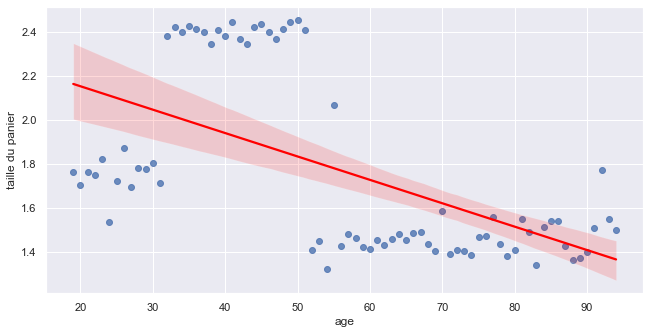

In [143]:
sns.regplot(x=df_panier_mean["age"], y=df_panier_mean["taille du panier"],line_kws={"color": "red"})

On voit que les donnees ne rentrent pas dans le modele lineaire.

On fait le test de normalité **shapiro** sur les deux variables avant de choisir la méthode pour le test de corrélation. </br>

H0 (Accepté) : l'échantillon correspond à une distribution normale. (P0 > 0,05) </br>
H1 (rejeté) : l'échantillon ne correspond pas à une distribution normale. </br>

In [145]:
# variable âge et variable nombre d'achat
shapiro(df_panier_mean["age"]) , shapiro(df_panier_mean["taille du panier"]) 

(ShapiroResult(statistic=0.9549235701560974, pvalue=0.008753503672778606),
 ShapiroResult(statistic=0.7821385860443115, pvalue=2.9776876520060114e-09))

Nos deux variable ne proviennent pas de distribution normal,  donc on va faire le **test non-parametrique de correlation de Spearman** 

#### ⚡Test statistique: </br>
H0:  il y a pas de lien entre age et la taille du panier moyen 
H1:  un lien correlation

In [147]:
df_panier_mean.corr(method="spearman")

,age,taille du panier
age,1.000000,-0.612085
taille du panier,-0.612085,1.000000


Text(0.5, 1.0, 'Correlation de Spearman')

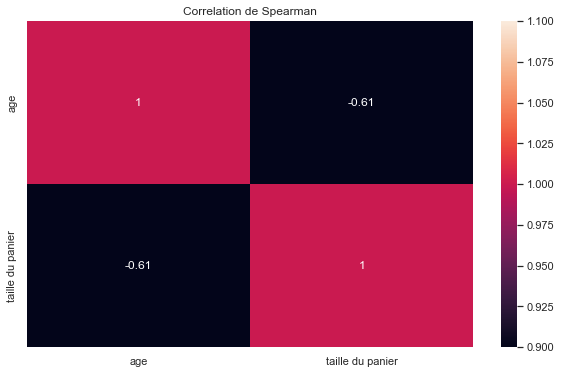

In [149]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_panier_mean.corr(method="spearman"), vmin=1, vmax=1, annot=True)
plt.title("Correlation de Spearman")

On obtient un coefficient de corrélation de -0.61. Il s' agit d'une corrélation modérée.</br>

|Correlation Coeffient (r<sub>s</sub>) |Interpretation|
|---|---|
|0.9< (r<sub>s</sub>) <1|Very strong|
|0.7< (r<sub>s</sub>) <0.9|Strong|
|**0.4< (r<sub>s</sub>) <0.7** |**Moderate**|
|0.2< (r<sub>s</sub>) <0.4|Weak|
|0< (r<sub>s</sub>) <0.2|No or very weak|

In [99]:
# On verifie la p-value
stats.spearmanr(df_panier["age"], df_panier["price"])

SpearmanrResult(correlation=-0.7606288448393711, pvalue=1.5702923018181533e-15)

#### ✔️conclusion
La p-value est sous le seuil de 0.05, donc **il y a bien un lien entre l'age et la taille du panier moyen**. Et il s'agit d'une corrélation modérée.
Le coéfficient étant négatif, on peut dire que lorsque l'âge augmente, la taille du panier moyen a tendance à baisser.

Afin de montrer graphiquement la répartition entre l'âge et la taille du panier moyen, 
je dessine des boîtes à moustaches en regroupant les âges par tranches d'âge.

In [123]:
df_merged_age=troisfichier.copy()
df_merged_age.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,age_group
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986,37,35-44
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0,f,1986,37,35-44
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0,f,1986,37,35-44
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0,f,1986,37,35-44
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0,f,1986,37,35-44


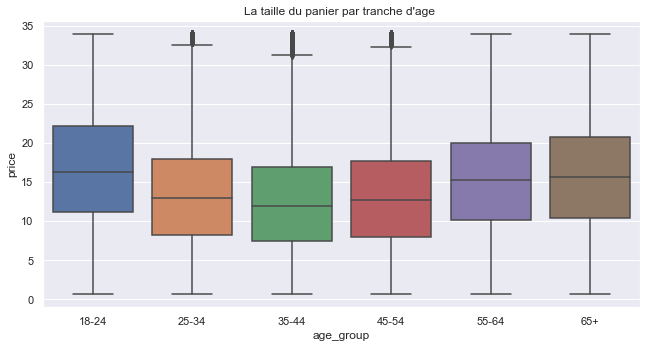

In [125]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10.7,5.27)})

Q1 = df_merged_age['price'].quantile(0.25)
Q3 = df_merged_age['price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df_merged_age['price'] >= Q1 - 1.5 * IQR) & (df_merged_age['price'] <= Q3 + 1.5 *IQR)
tt=df_merged_age.loc[filter]  

sns.boxplot(x=tt["age_group"], y=tt["price"]).set_title('La taille du panier par tranche d\'age ')
plt.show()

### 🍄5. Age &  categories des livres achetés : 
##### Il y a t-il un lien entre la categorie de livre est l'age du client ?

je calcule le nombre de ventes pour faire le diagramme de nuage à point par catégorie et l'âge pour observer la corrélation et la tendance.

In [154]:
df_categ_cli=troisfichier.groupby(['age','categ']).count().reset_index()
df_categ_cli.rename(columns={"session_id" :"nb livres achetés", }, inplace=True)
df_categ_cli.head(2)

,age,categ,id_prod,date,nb livres achetés,client_id,price,sex,birth,age_group
0,19,0,3418,3418,3418,3418,3418,3418,3418,3418
1,19,1,5719,5719,5719,5719,5719,5719,5719,5719


In [155]:
tt0=df_categ_cli.loc[tt["categ"]==0,:]
tt1=df_categ_cli.loc[tt["categ"]==1,:]
tt2=df_categ_cli.loc[tt["categ"]==2,:]
tt2.head(2)

,age,categ,id_prod,date,nb livres achetés,client_id,price,sex,birth,age_group
2,19,2,6012,6012,6012,6012,6012,6012,6012,6012
5,20,2,1784,1784,1784,1784,1784,1784,1784,1784


Text(0.5, 1.0, 'Nombre de ventes par age - categorie 2')

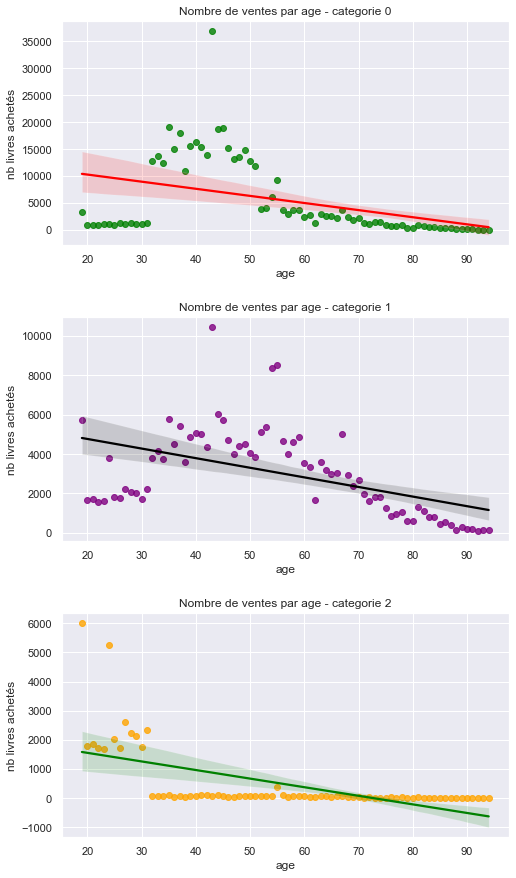

In [156]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 13),sharey=False)
fig.tight_layout(pad=4.0) 
sns.regplot(ax=axes[0], x=tt0["age"], y=tt0["nb livres achetés"],scatter_kws={"color": "green"}, line_kws={"color": "red"})
axes[0].set_title('Nombre de ventes par age - categorie 0')
sns.regplot(ax=axes[1], x=tt1["age"], y=tt1["nb livres achetés"],scatter_kws={"color": "purple"}, line_kws={"color": "black"})
axes[1].set_title('Nombre de ventes par age - categorie 1')
sns.regplot(ax=axes[2],x=tt2["age"], y=tt2["nb livres achetés"],scatter_kws={"color": "orange"},line_kws={"color": "green"})
axes[2].set_title('Nombre de ventes par age - categorie 2')

Dès la première diagramme du haut, on peut voir que le groupe entre 30 et 50 ans est le groupe qui achète le plus de livres de catégorie 0. </br>
D'après la diagramme au milieu, on constate que le groupe avec le plus grand nombre d'achats de livres de catégorie 1 apparaît entre 30 et 60 ans.</br>
Dans la diagramme du bas, on voit que le groupe qui achète le plus de livres de catégorie 2 se situe entre 20 et 30 ans, ce qui signifie que les livres de catégorie 2 sont les plus populaires auprès des jeunes.</br>

ici, on a **une variable quantitative et une variable qualitative**.</br>

##### Le choix du test.</br>
ANOVA ( parametrique ) , ou son alternative non-parametrique Kruskal-Wallis.</br>
read: Le test de Kruskal-Wallis est souvent utilisé comme une alternative à l'ANOVA dans le cas où l'hypothèse de normalité n'est pas acceptable.</br>


Si on veut utiliser ANOVA, on doit vérifier les conditions préalables:</br>
 - Variable x doit avoir au moins 2 modalités.</br>
 - Il doit s'agir d'une distribution normal.</br>

##### Est ce que la répartition de l'age par catégorie suit une distribution normal? 

Ceci est une condition si l'on veux utiliser anova.

In [126]:
c0= troisfichier[troisfichier.categ==0]
c1= troisfichier[troisfichier.categ==1]
c2= troisfichier[troisfichier.categ==2]

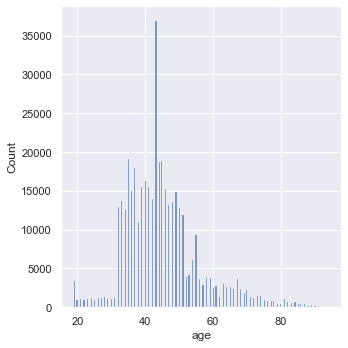

In [133]:
#TODO: Put together the plots
sns.displot(c0.age)

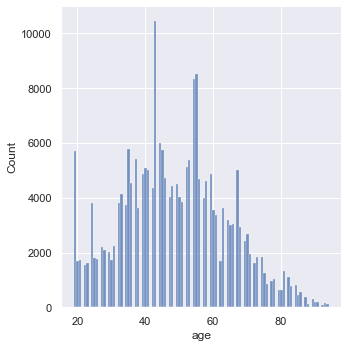

In [132]:
sns.displot(c1.age)

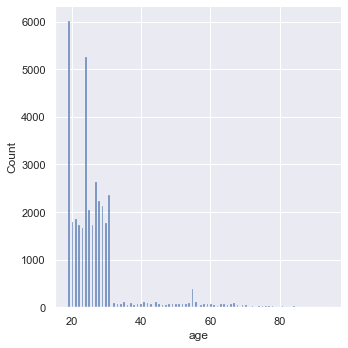

In [134]:
sns.displot(c2.age)

On fait le test de normalité **shapiro** sur les deux variables pour tester la normalité. </br>

- H0 (Accepté) : l'échantillon correspond à une distribution normale. (P0 > 0,05) </br>
- H1 (rejeté) : l'échantillon ne correspond pas à une distribution normale. </br>

In [157]:
dfc0 = c0.sample(4000)
shapiro(dfc0.age) 

ShapiroResult(statistic=0.9312242269515991, pvalue=1.6434694636309676e-39)

In [158]:
dfc1 = c1.sample(4000)
shapiro(dfc1.age) 

ShapiroResult(statistic=0.989507794380188, pvalue=1.1870017967334306e-16)

In [159]:
dfc2 = c2.sample(4000)
shapiro(dfc2.age) 

ShapiroResult(statistic=0.6715105175971985, pvalue=0.0)

Anisi, **La P value est inférieur à 0.05**. Donc hypothese null est rejeté; **L'âge par catégorie n'est pas issue d'une distribution normal**. </br>
On ne peut donc pas utiliser anova. **On va faire le test de Kruskal-Wallis**.
Il est considéré comme l'équivalent non paramétrique de 'One-Way ANOVA'.

#### ⚡Test statistique: </br>
Pour le test de Kruskal-Wallis on pose les hypotheses suivantes:
- H0:  il y a pas de lien entre l'âge et la categorie des livres achetés </br>
- H1:  un lien corrélation</br>


In [160]:
#perform Kruskal-Wallis Test 
stats.kruskal(c0['age'], c1['age'], c2['age'])

KruskalResult(statistic=79346.09938564085, pvalue=0.0)

La p value est inférieur à 0.05, donc **hypothèse nulle est rejetée**. </br>
Ainsi, on peut conclure  qu'**il y a bien un lien entre l'age et la catégorie de livre achetés**.

# Conclusion

Dans ce rapport, on a examiné les differents indicateurs du CA, fait un analyse univarié et bivarié de differentes variables tel le nombre de ventes, la categorie achetée, le genre et l'age des clients, etc, On a aussi demontré grace à des tests statistiques qu'il y a une correlation entre le genre et l'age des clients et certaines variables tels que la taille du panier, la frequence d'achat et les catégories achetées.